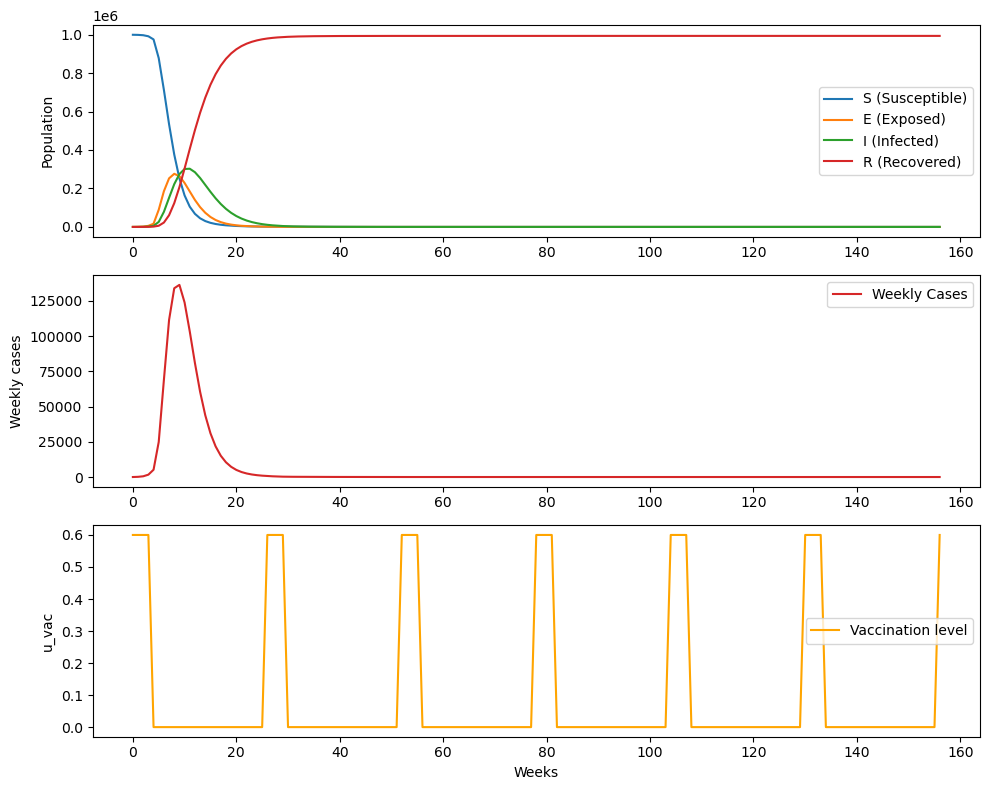

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple
from scipy.integrate import solve_ivp

# ==========================================
# SEIRC-C model with vaccination campaigns
# ==========================================
kappa = 5000  # environmental parameter

@dataclass
class Params:
    N: float
    beta1: float
    beta2: float
    sigma: float
    gamma: float
    mu: float
    delta: float
    eta: float
    epsilon: float
    kappa: float
    u_vac: float = 0.0
    u_san: float = 0.0
    u_treat: float = 0.0


@dataclass
class ControlGains:
    k_s_to_delta: float = 9.0
    k_s_to_beta2: float = 0.98
    k_s_to_eta: float = 0.6
    k_s_to_eps: float = 0.8
    k_v_to_beta: float = 1.0
    k_t_to_gamma: float = 3.0
    k_t_to_mu: float = 0.9


def _effective_params(p: Params, k: ControlGains):
    u_v = float(np.clip(p.u_vac, 0, 1))
    u_s = float(np.clip(p.u_san, 0, 1))
    u_t = float(np.clip(p.u_treat, 0, 1))

    susc_scale = (1.0 - k.k_v_to_beta * u_v)
    delta_eff = p.delta * (1.0 + k.k_s_to_delta * u_s)
    beta2_eff = p.beta2 * max(0.0, 1.0 - k.k_s_to_beta2 * u_s)
    eta_eff = p.eta * (1.0 - k.k_s_to_eta * u_s)
    eps_eff = p.epsilon * (1.0 - k.k_s_to_eps * u_s)
    gamma_eff = p.gamma * (1.0 + k.k_t_to_gamma * u_t)
    mu_eff = p.mu * (1.0 - k.k_t_to_mu * u_t)

    return dict(
        susc_scale=susc_scale,
        delta_eff=delta_eff,
        beta2_eff=beta2_eff,
        eta_eff=eta_eff,
        eps_eff=eps_eff,
        gamma_eff=gamma_eff,
        mu_eff=mu_eff
    )


def rhs(t, y, p: Params, gains: ControlGains):
    S, E, I, R, C, A, D = y
    eff = _effective_params(p, gains)

    lambda_dir = p.beta1 * I / p.N
    lambda_env = eff["beta2_eff"] * C / (C + kappa)
    lambda_tot = eff["susc_scale"] * (lambda_dir + lambda_env)

    dS = -lambda_tot * S
    dE = lambda_tot * S - p.sigma * E
    dI = p.sigma * E - eff["gamma_eff"] * I - eff["mu_eff"] * I
    dR = eff["gamma_eff"] * I
    dC = eff["eta_eff"] * I * (1.0 - C / p.kappa) + eff["eps_eff"] * C - eff["delta_eff"] * C
    dA = p.sigma * E
    dD = eff["mu_eff"] * I

    return np.array([dS, dE, dI, dR, dC, dA, dD], float)


# =============================
# Vaccination campaign builder
# =============================
def build_pulse_campaign(t_weeks, interval=26, duration_weeks=4, intensity=0.6):
    """Create a pulse vaccination campaign repeating every interval weeks"""
    u_vac = np.zeros_like(t_weeks, float)
    for start in range(0, int(t_weeks[-1]) + 1, interval):
        end = start + duration_weeks
        idx = (t_weeks >= start) & (t_weeks < end)
        u_vac[idx] = intensity
    return u_vac


# =============================
# Time-varying simulation
# =============================
def simulate_timevarying(t_weeks, y0, params: Params, gains: ControlGains, u_vac_t):
    solY = [y0]
    for i in range(1, len(t_weeks)):
        tspan = [t_weeks[i - 1], t_weeks[i]]
        params.u_vac = u_vac_t[i - 1]
        sol = solve_ivp(lambda t, y: rhs(t, y, params, gains),
                        tspan, solY[-1], t_eval=[t_weeks[i]], method="RK45")
        solY.append(sol.y[:, -1])
    solY = np.array(solY)
    S, E, I, R, C, A, D = solY.T
    return dict(t=t_weeks, S=S, E=E, I=I, R=R, C=C, cum_inc=A, cum_deaths=D)


# =============================
# Plotting
# =============================
def plot_results(result, u_vac_t):
    t = result["t"]
    plt.figure(figsize=(10, 8))
    plt.subplot(3, 1, 1)
    plt.plot(t, result["S"], label="S (Susceptible)")
    plt.plot(t, result["E"], label="E (Exposed)")
    plt.plot(t, result["I"], label="I (Infected)")
    plt.plot(t, result["R"], label="R (Recovered)")
    plt.legend()
    plt.ylabel("Population")

    plt.subplot(3, 1, 2)
    weekly_cases = np.diff(result["cum_inc"], prepend=0)
    plt.plot(t, weekly_cases, label="Weekly Cases", color='tab:red')
    plt.ylabel("Weekly cases")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(t, u_vac_t, label="Vaccination level", color='orange')
    plt.xlabel("Weeks")
    plt.ylabel("u_vac")
    plt.legend()

    plt.tight_layout()
    plt.show()


# =============================
# Example run
# =============================
if __name__ == "__main__":
    t = np.arange(0, 156 + 1)  # 3 years (156 weeks)
    params = Params(
        N=1_000_000,
        beta1=0.8, beta2=0.4,
        sigma=1/2.0, gamma=1/3.0, mu=0.002,
        delta=0.1, eta=0.2, epsilon=0.05, kappa=5000
    )
    gains = ControlGains()
    y0 = (999000, 100, 50, 0, 10, 0, 0)

    # Vaccination every 6 months (26 weeks) for 4 weeks
    u_vac_t = build_pulse_campaign(t, interval=26, duration_weeks=4, intensity=0.6)

    result = simulate_timevarying(t, y0, params, gains, u_vac_t)
    plot_results(result, u_vac_t)


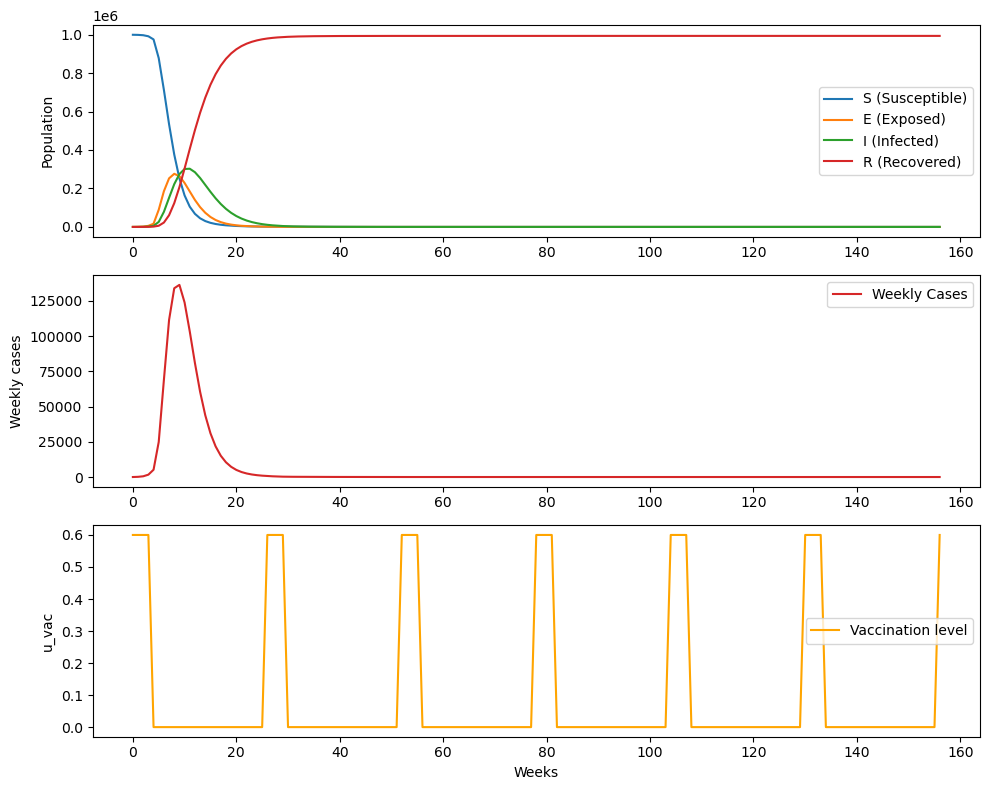

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple
from scipy.integrate import solve_ivp

# ==========================================
# SEIRC-C model with vaccination campaigns
# ==========================================
kappa = 5000  # environmental parameter

@dataclass
class Params:
    N: float
    beta1: float
    beta2: float
    sigma: float
    gamma: float
    mu: float
    delta: float
    eta: float
    epsilon: float
    kappa: float
    u_vac: float = 0.0
    u_san: float = 0.0
    u_treat: float = 0.0


@dataclass
class ControlGains:
    k_s_to_delta: float = 9.0
    k_s_to_beta2: float = 0.98
    k_s_to_eta: float = 0.6
    k_s_to_eps: float = 0.8
    k_v_to_beta: float = 1.0
    k_t_to_gamma: float = 3.0
    k_t_to_mu: float = 0.9


def _effective_params(p: Params, k: ControlGains):
    u_v = float(np.clip(p.u_vac, 0, 1))
    u_s = float(np.clip(p.u_san, 0, 1))
    u_t = float(np.clip(p.u_treat, 0, 1))

    susc_scale = (1.0 - k.k_v_to_beta * u_v)
    delta_eff = p.delta * (1.0 + k.k_s_to_delta * u_s)
    beta2_eff = p.beta2 * max(0.0, 1.0 - k.k_s_to_beta2 * u_s)
    eta_eff = p.eta * (1.0 - k.k_s_to_eta * u_s)
    eps_eff = p.epsilon * (1.0 - k.k_s_to_eps * u_s)
    gamma_eff = p.gamma * (1.0 + k.k_t_to_gamma * u_t)
    mu_eff = p.mu * (1.0 - k.k_t_to_mu * u_t)

    return dict(
        susc_scale=susc_scale,
        delta_eff=delta_eff,
        beta2_eff=beta2_eff,
        eta_eff=eta_eff,
        eps_eff=eps_eff,
        gamma_eff=gamma_eff,
        mu_eff=mu_eff
    )


def rhs(t, y, p: Params, gains: ControlGains):
    S, E, I, R, C, A, D = y
    eff = _effective_params(p, gains)

    lambda_dir = p.beta1 * I / p.N
    lambda_env = eff["beta2_eff"] * C / (C + kappa)
    lambda_tot = eff["susc_scale"] * (lambda_dir + lambda_env)

    dS = -lambda_tot * S
    dE = lambda_tot * S - p.sigma * E
    dI = p.sigma * E - eff["gamma_eff"] * I - eff["mu_eff"] * I
    dR = eff["gamma_eff"] * I
    dC = eff["eta_eff"] * I * (1.0 - C / p.kappa) + eff["eps_eff"] * C - eff["delta_eff"] * C
    dA = p.sigma * E
    dD = eff["mu_eff"] * I

    return np.array([dS, dE, dI, dR, dC, dA, dD], float)


# =============================
# Vaccination campaign builder
# =============================
def build_pulse_campaign(t_weeks, interval=26, duration_weeks=4, intensity=0.6):
    """Create a pulse vaccination campaign repeating every interval weeks"""
    u_vac = np.zeros_like(t_weeks, float)
    for start in range(0, int(t_weeks[-1]) + 1, interval):
        end = start + duration_weeks
        idx = (t_weeks >= start) & (t_weeks < end)
        u_vac[idx] = intensity
    return u_vac


# =============================
# Time-varying simulation
# =============================
def simulate_timevarying(t_weeks, y0, params: Params, gains: ControlGains, u_vac_t):
    solY = [y0]
    for i in range(1, len(t_weeks)):
        tspan = [t_weeks[i - 1], t_weeks[i]]
        params.u_vac = u_vac_t[i - 1]
        sol = solve_ivp(lambda t, y: rhs(t, y, params, gains),
                        tspan, solY[-1], t_eval=[t_weeks[i]], method="RK45")
        solY.append(sol.y[:, -1])
    solY = np.array(solY)
    S, E, I, R, C, A, D = solY.T
    return dict(t=t_weeks, S=S, E=E, I=I, R=R, C=C, cum_inc=A, cum_deaths=D)


# =============================
# Plotting
# =============================
def plot_results(result, u_vac_t):
    t = result["t"]
    plt.figure(figsize=(10, 8))
    plt.subplot(3, 1, 1)
    plt.plot(t, result["S"], label="S (Susceptible)")
    plt.plot(t, result["E"], label="E (Exposed)")
    plt.plot(t, result["I"], label="I (Infected)")
    plt.plot(t, result["R"], label="R (Recovered)")
    plt.legend()
    plt.ylabel("Population")

    plt.subplot(3, 1, 2)
    weekly_cases = np.diff(result["cum_inc"], prepend=0)
    plt.plot(t, weekly_cases, label="Weekly Cases", color='tab:red')
    plt.ylabel("Weekly cases")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(t, u_vac_t, label="Vaccination level", color='orange')
    plt.xlabel("Weeks")
    plt.ylabel("u_vac")
    plt.legend()

    plt.tight_layout()
    plt.show()


# =============================
# Example run
# =============================
if __name__ == "__main__":
    t = np.arange(0, 156 + 1)  # 3 years (156 weeks)
    params = Params(
        N=1_000_000,
        beta1=0.8, beta2=0.4,
        sigma=1/2.0, gamma=1/3.0, mu=0.002,
        delta=0.1, eta=0.2, epsilon=0.05, kappa=5000
    )
    gains = ControlGains()
    y0 = (999000, 100, 50, 0, 10, 0, 0)

    # Vaccination every 6 months (26 weeks) for 4 weeks
    u_vac_t = build_pulse_campaign(t, interval=26, duration_weeks=4, intensity=0.6)

    result = simulate_timevarying(t, y0, params, gains, u_vac_t)
    plot_results(result, u_vac_t)


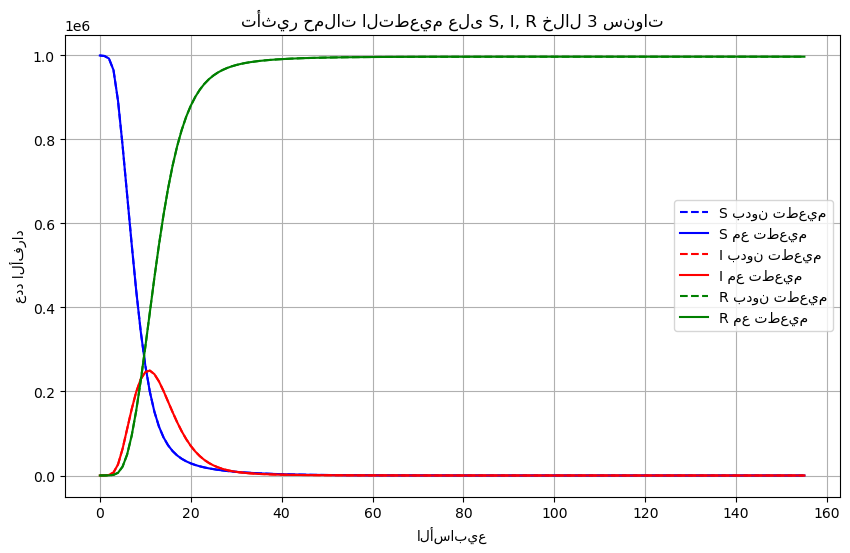

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict
from scipy.integrate import solve_ivp

# =========================
# SEIRC-C Model (with vaccination campaigns)
# =========================
kappa = 5000

@dataclass
class Params:
    N: float
    beta1: float
    beta2: float
    sigma: float
    gamma: float
    mu: float
    delta: float
    eta: float
    epsilon: float
    kappa: float
    u_vac: float = 0.0
    u_san: float = 0.0
    u_treat: float = 0.0

@dataclass
class ControlGains:
    k_s_to_delta: float = 9.0
    k_s_to_beta2: float = 0.98
    k_s_to_eta: float = 0.6
    k_s_to_eps: float = 0.8
    k_v_to_beta: float = 1.0
    k_t_to_gamma: float = 3.0
    k_t_to_mu: float = 0.9

def _effective_params(p: Params, k: ControlGains):
    u_v  = float(np.clip(p.u_vac,  0, 1))
    u_s  = float(np.clip(p.u_san,  0, 1))
    u_t  = float(np.clip(p.u_treat,0, 1))

    susc_scale = (1.0 - k.k_v_to_beta * u_v)
    delta_eff = p.delta * (1.0 + k.k_s_to_delta * u_s)
    beta2_eff = p.beta2 * max(0.0, 1.0 - k.k_s_to_beta2 * u_s)
    eta_eff   = p.eta   * (1.0 - k.k_s_to_eta   * u_s)
    eps_eff   = p.epsilon * (1.0 - k.k_s_to_eps * u_s)
    gamma_eff = p.gamma * (1.0 + k.k_t_to_gamma * u_t)
    mu_eff    = p.mu    * (1.0 - k.k_t_to_mu    * u_t)

    return dict(
        susc_scale=susc_scale, delta_eff=delta_eff, beta2_eff=beta2_eff,
        eta_eff=eta_eff, eps_eff=eps_eff, gamma_eff=gamma_eff, mu_eff=mu_eff
    )

def rhs(t, y, p: Params, gains: ControlGains):
    S, E, I, R, C, A, D = y
    eff = _effective_params(p, gains)

    lambda_dir = p.beta1 * I / p.N
    lambda_env = eff["beta2_eff"] * C / (C + kappa)
    lambda_tot = eff["susc_scale"] * (lambda_dir + lambda_env)

    dS = - lambda_tot * S
    dE =   lambda_tot * S - p.sigma * E
    dI =   p.sigma * E - eff["gamma_eff"] * I - eff["mu_eff"] * I
    dR =   eff["gamma_eff"] * I
    dC =   eff["eta_eff"] * I * (1.0 - C / p.kappa) + eff["eps_eff"] * C - eff["delta_eff"] * C
    dA = p.sigma * E
    dD = eff["mu_eff"] * I

    return np.array([dS, dE, dI, dR, dC, dA, dD], float)

# -------------------------
# Vaccination campaign pulses
# -------------------------
def build_pulse_campaign(t_weeks, interval=26, duration_weeks=4, intensity=0.6):
    u_vac_t = np.zeros_like(t_weeks)
    for i, t in enumerate(t_weeks):
        phase = (t % interval)
        if phase < duration_weeks:
            u_vac_t[i] = intensity
    return u_vac_t

# -------------------------
# Simulation with time-varying vaccination
# -------------------------
def simulate_timevarying(t_weeks, y0, params, gains, u_vac_t):
    y = np.zeros((len(t_weeks), len(y0)))
    y[0, :] = y0
    for i in range(1, len(t_weeks)):
        t_span = (t_weeks[i-1], t_weeks[i])
        p_now = Params(**{**params.__dict__, "u_vac": u_vac_t[i]})
        sol = solve_ivp(lambda t, y: rhs(t, y, p_now, gains),
                        t_span, y[i-1, :], method="LSODA", rtol=1e-6, atol=1e-8)
        y[i, :] = sol.y[:, -1]
    return y

# -------------------------
# Plot comparison
# -------------------------
def plot_comparison(t, results_no_vac, results_with_vac):
    plt.figure(figsize=(10,6))
    plt.plot(t, results_no_vac[:,0], 'b--', label='S بدون تطعيم')
    plt.plot(t, results_with_vac[:,0], 'b-', label='S مع تطعيم')
    plt.plot(t, results_no_vac[:,2], 'r--', label='I بدون تطعيم')
    plt.plot(t, results_with_vac[:,2], 'r-', label='I مع تطعيم')
    plt.plot(t, results_no_vac[:,3], 'g--', label='R بدون تطعيم')
    plt.plot(t, results_with_vac[:,3], 'g-', label='R مع تطعيم')
    plt.title("تأثير حملات التطعيم على S, I, R خلال 3 سنوات")
    plt.xlabel("الأسابيع")
    plt.ylabel("عدد الأفراد")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------
# Main
# -------------------------
if __name__ == "__main__":
    t_weeks = np.arange(0, 156)  # 3 سنوات
    params = Params(
        N=1_000_000, beta1=0.7, beta2=0.2,
        sigma=1/2, gamma=1/3, mu=0.001,
        delta=0.05, eta=0.4, epsilon=0.05, kappa=5000
    )
    gains = ControlGains()
    y0 = (999000, 100, 50, 0, 10, 0, 0)

    # بدون تطعيم
    u_vac_none = np.zeros_like(t_weeks)
    res_no_vac = simulate_timevarying(t_weeks, y0, params, gains, u_vac_none)

    # مع حملات تطعيم
    u_vac_campaign = build_pulse_campaign(t_weeks, interval=26, duration_weeks=4, intensity=0.6)
    res_with_vac = simulate_timevarying(t_weeks, y0, params, gains, u_vac_campaign)

    # رسم المقارنة
    plot_comparison(t_weeks, res_no_vac, res_with_vac)


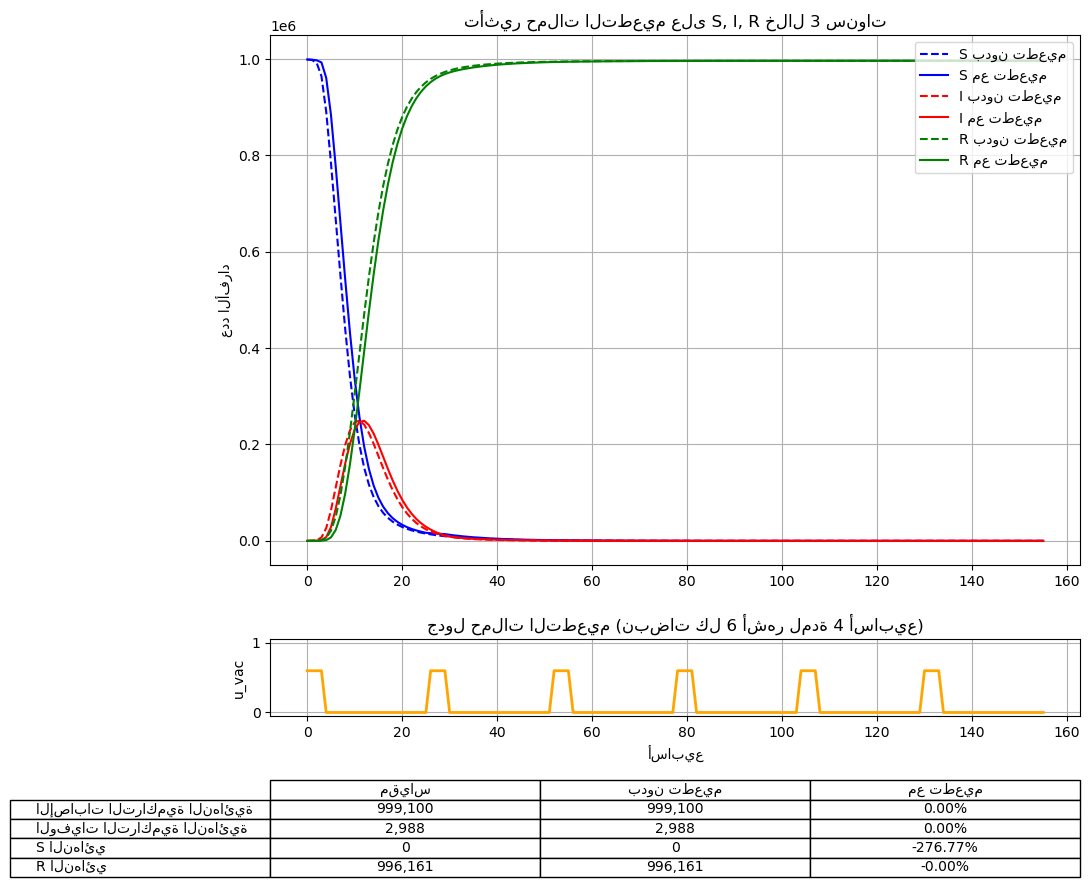

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.integrate import solve_ivp

# =========================
# SEIRC-C Model (with vaccination campaigns + results table)
# =========================
kappa = 5000

@dataclass
class Params:
    N: float
    beta1: float
    beta2: float
    sigma: float
    gamma: float
    mu: float
    delta: float
    eta: float
    epsilon: float
    kappa: float
    u_vac: float = 0.0
    u_san: float = 0.0
    u_treat: float = 0.0

@dataclass
class ControlGains:
    k_s_to_delta: float = 9.0
    k_s_to_beta2: float = 0.98
    k_s_to_eta: float = 0.6
    k_s_to_eps: float = 0.8
    k_v_to_beta: float = 1.0
    k_t_to_gamma: float = 3.0
    k_t_to_mu: float = 0.9

def _effective_params(p: Params, k: ControlGains):
    u_v  = float(np.clip(p.u_vac,  0, 1))
    u_s  = float(np.clip(p.u_san,  0, 1))
    u_t  = float(np.clip(p.u_treat,0, 1))

    susc_scale = (1.0 - k.k_v_to_beta * u_v)
    delta_eff = p.delta * (1.0 + k.k_s_to_delta * u_s)
    beta2_eff = p.beta2 * max(0.0, 1.0 - k.k_s_to_beta2 * u_s)
    eta_eff   = p.eta   * (1.0 - k.k_s_to_eta   * u_s)
    eps_eff   = p.epsilon * (1.0 - k.k_s_to_eps * u_s)
    gamma_eff = p.gamma * (1.0 + k.k_t_to_gamma * u_t)
    mu_eff    = p.mu    * (1.0 - k.k_t_to_mu    * u_t)

    return dict(
        susc_scale=susc_scale, delta_eff=delta_eff, beta2_eff=beta2_eff,
        eta_eff=eta_eff, eps_eff=eps_eff, gamma_eff=gamma_eff, mu_eff=mu_eff
    )

def rhs(t, y, p: Params, gains: ControlGains):
    S, E, I, R, C, A, D = y
    eff = _effective_params(p, gains)

    lambda_dir = p.beta1 * I / p.N
    lambda_env = eff["beta2_eff"] * C / (C + kappa)
    lambda_tot = eff["susc_scale"] * (lambda_dir + lambda_env)

    dS = - lambda_tot * S
    dE =   lambda_tot * S - p.sigma * E
    dI =   p.sigma * E - eff["gamma_eff"] * I - eff["mu_eff"] * I
    dR =   eff["gamma_eff"] * I
    dC =   eff["eta_eff"] * I * (1.0 - C / p.kappa) + eff["eps_eff"] * C - eff["delta_eff"] * C
    dA = p.sigma * E
    dD = eff["mu_eff"] * I

    return np.array([dS, dE, dI, dR, dC, dA, dD], float)

# -------------------------
# Vaccination campaign pulses
# -------------------------
def build_pulse_campaign(t_weeks, interval=26, duration_weeks=4, intensity=0.6):
    u_vac_t = np.zeros_like(t_weeks, dtype=float)
    for i, tw in enumerate(t_weeks):
        if (tw % interval) < duration_weeks:
            u_vac_t[i] = intensity
    return u_vac_t

# -------------------------
# Simulation with time-varying vaccination
# -------------------------
def simulate_timevarying(t_weeks, y0, params, gains, u_vac_t):
    # y columns: S,E,I,R,C,A,D
    y = np.zeros((len(t_weeks), len(y0)), dtype=float)
    y[0, :] = y0
    for i in range(1, len(t_weeks)):
        t_span = (t_weeks[i-1], t_weeks[i])
        # update only u_vac (others unchanged)
        p_now = Params(**{**params.__dict__, "u_vac": float(u_vac_t[i])})
        sol = solve_ivp(lambda t, y: rhs(t, y, p_now, gains),
                        t_span, y[i-1, :], method="LSODA", rtol=1e-6, atol=1e-8)
        y[i, :] = sol.y[:, -1]
    return y

# -------------------------
# Plot comparison + vaccination pulses + results table
# -------------------------
def plot_and_table(t, res_no, res_with, u_vac_t):
    # compute numeric summaries
    # cum_inc is column 5 (A), cum_deaths col 6 (D)
    cum_no = res_no[-1, 5]
    cum_with = res_with[-1, 5]
    deaths_no = res_no[-1, 6]
    deaths_with = res_with[-1, 6]
    final_S_no = res_no[-1, 0]
    final_S_with = res_with[-1, 0]
    final_R_no = res_no[-1, 3]
    final_R_with = res_with[-1, 3]

    # percent reductions (handle divide-by-zero safely)
    pct_cases_red = 100.0 * (cum_no - cum_with) / cum_no if cum_no > 0 else 0.0
    pct_deaths_red = 100.0 * (deaths_no - deaths_with) / deaths_no if deaths_no > 0 else 0.0

    # prepare figure with 3 rows: top = main comparison, middle = pulses, bottom = table
    fig = plt.figure(figsize=(11, 9))
    gs = fig.add_gridspec(6, 1)
    ax_main = fig.add_subplot(gs[0:4, 0])   # big top
    ax_pulses = fig.add_subplot(gs[4, 0])   # pulses thin
    ax_table = fig.add_subplot(gs[5, 0])    # table thin

    # main comparison: S (col 0), I (col 2), R (col 3)
    ax_main.plot(t, res_no[:, 0], 'b--', label='S بدون تطعيم')
    ax_main.plot(t, res_with[:, 0], 'b-', label='S مع تطعيم')
    ax_main.plot(t, res_no[:, 2], 'r--', label='I بدون تطعيم')
    ax_main.plot(t, res_with[:, 2], 'r-', label='I مع تطعيم')
    ax_main.plot(t, res_no[:, 3], 'g--', label='R بدون تطعيم')
    ax_main.plot(t, res_with[:, 3], 'g-', label='R مع تطعيم')
    ax_main.set_ylabel('عدد الأفراد')
    ax_main.set_title('تأثير حملات التطعيم على S, I, R خلال 3 سنوات')
    ax_main.grid(True)
    ax_main.legend(loc='upper right')

    # pulses
    ax_pulses.plot(t, u_vac_t, color='orange', linewidth=2)
    ax_pulses.set_ylim(-0.05, 1.05)
    ax_pulses.set_ylabel('u_vac')
    ax_pulses.set_xlabel('أسابيع')
    ax_pulses.set_title('جدول حملات التطعيم (نبضات كل 6 أشهر لمدة 4 أسابيع)')
    ax_pulses.grid(True)

    # table data
    col_labels = ["مقياس", "بدون تطعيم", "مع تطعيم", "التحسن (%)"]
    row_labels = ["الإصابات التراكمية النهائية", "الوفيات التراكمية النهائية", "S النهائي", "R النهائي"]
    table_vals = [
        [f"{cum_no:,.0f}", f"{cum_with:,.0f}", f"{pct_cases_red:.2f}%"],
        [f"{deaths_no:,.0f}", f"{deaths_with:,.0f}", f"{pct_deaths_red:.2f}%"],
        [f"{final_S_no:,.0f}", f"{final_S_with:,.0f}", f"{100.0*(final_S_no-final_S_with)/final_S_no:.2f}%" if final_S_no>0 else "0.00%"],
        [f"{final_R_no:,.0f}", f"{final_R_with:,.0f}", f"{100.0*(final_R_with-final_R_no)/final_R_no:.2f}%" if final_R_no>0 else "0.00%"]
    ]

    # hide axes for table and display matplotlib table
    ax_table.axis('off')
    table = ax_table.table(cellText=table_vals,
                           rowLabels=row_labels,
                           colLabels=col_labels,
                           cellLoc='center',
                           loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.tight_layout()
    plt.show()

# -------------------------
# Main execution
# -------------------------
if __name__ == "__main__":
    # timeline
    t_weeks = np.arange(0, 156)  # 3 years

    # parameters and initial conditions
    params = Params(
        N=1_000_000, beta1=0.7, beta2=0.2,
        sigma=1/2, gamma=1/3, mu=0.001,
        delta=0.05, eta=0.4, epsilon=0.05, kappa=5000
    )
    gains = ControlGains()
    y0 = (999000.0, 100.0, 50.0, 0.0, 10.0, 0.0, 0.0)

    # simulate without vaccination
    u_none = np.zeros_like(t_weeks, dtype=float)
    res_no_vac = simulate_timevarying(t_weeks, y0, params, gains, u_none)

    # simulate with periodic vaccination campaigns
    u_campaign = build_pulse_campaign(t_weeks, interval=26, duration_weeks=4, intensity=0.6)
    res_with_vac = simulate_timevarying(t_weeks, y0, params, gains, u_campaign)

    # plot and show table
    plot_and_table(t_weeks, res_no_vac, res_with_vac, u_campaign)
